# Data Cube Cloud Statistics

This notebook explores Landsat-7 and Landsat-8 Data Cubes and reports cloud statistics for selected regions within a cube. This is valuable information for performing analysis. For example, if there are extensive clouds for a season it may significantly impact the mosaic product or index values. Another example is that a user may want to find a single date when there are few clouds to assess land features.

In [1]:
import os
import sys
sys.path.append('/notebooks')

# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data Cube Configuration
import datacube
dc = datacube.Datacube(app = 'my_app')
# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

In [3]:
## LS8 Caqueta
# Latitude:  (0.000134747292617865, 1.077843593651382)  
# Longitude: (-74.91935994831539, -73.30266193148462)  
# '2013-04-13', '2018-03-26'
# Resolution: (-0.000269494585236, 0.000269494585236)

## LS8 Vietnam
# Latitude:  (10.513927001104687, 12.611133863411238)  
# Longitude: (106.79005909290998, 108.91906631627438)  
# '2014-01-14', '2016-12-21'
# Resolution: (-0.000269494585236, 0.000269494585236)

## LS7 Caqueta
# Latitude:  (0.000134747292617865, 1.077843593651382)  
# Longitude: (-74.91935994831539, -73.30266193148462)  
# '1999-08-21', '2018-03-25'
# Resolution: (-0.000269494585236, 0.000269494585236)

## LS7 Lake Baringo
# Latitude:  (0.4997747685, 0.7495947795)  
# Longitude: (35.9742163305, 36.473586859499996)  
# '2005-01-08', '2016-12-24'
# Resolution: (-0.000269493, 0.000269493)

In [4]:
# CHANGE HERE >>>>>>>>>>>>>>>>>

# Select a Product and Platform
# product = ls7_collection1_AMA_ingest
# platform = "LANDSAT_7"

# product = 'ls8_collection1_AMA_ingest'
from utils.dea_tools.datahandling import mostcommon_crs

# product='ls8_level1_usgs'
product='ls8_c01_l2_usgs_sr_scene'
platform="LANDSAT_8"
lat, lon = 14.4595, 74.4799
buffer = 0.05
latitude = (lat - buffer, lat + buffer)
longitude = (lon - buffer, lon + buffer)
resolution = (-30, 30)
time_extents = ('2021-01-01', '2021-06-01')

query=dict(latitude=latitude,
           longitude=longitude,
           time=time_extents)

output_crs = mostcommon_crs(dc=dc, product=product, query=query)

output_crs

'PROJCS["WGS 84 / UTM zone 43N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32643"]]'

In [5]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>
# Select an analysis region (Lat-Lon) within the extents listed above. 
# HINT: Keep your region small (<0.5 deg square) to avoid memory overload issues
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment

#Sub-region selection - e.g Vietnam
# latitude = (11.3124, 10.9124)
# longitude = (106.9170, 107.3170) 
# time_extents = ('2014-01-01', '2016-01-01')

In [6]:
# The code below renders a map that can be used to view the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude,longitude)

# Cloud Coverage 

In [7]:
import datacube
from utils.data_cube_utilities.dc_mosaic import ls8_unpack_qa, ls7_unpack_qa 
import numpy as np
from functools import partial  
import pandas as pd

def build_cloud_coverage_table_landsat(product   = None,
                               platform  = None,
                               latitude  = None,
                               longitude = None,
                               time      = None,
                               output_crs = None,
                               resolution = None,
                               dc        = None):

    if product   is None: raise Exception("product argument is required")
    if platform  is None: raise Exception("platform argument is required")
    if latitude  is None: raise Exception("latitude argument is required")
    if longitude is None: raise Exception("longitude argument is required")
 
    def clean_mask(ds, unpacking_func, bands):
        masks = [unpacking_func(ds, band) for band in bands]
        return np.logical_or(*masks).values
    
    unpack_function = {"LANDSAT_7": ls7_unpack_qa,
                       "LANDSAT_8": ls8_unpack_qa}

    dc = datacube.Datacube(app = "")
    
    load_params = dict(product = product,
                       platform = platform,
                       latitude = latitude,
                       longitude = longitude,
                       output_crs = output_crs,
                       resolution = resolution,
                       time       = time,
                       measurements = ['pixel_qa'])
#                        measurements = ['quality'])
    
    
    if time is not None: 
        load_params["time"] = time
        
    product = dc.load(**load_params)
       
    times  = list(product.time.values)
    scene_slice_list = list(map(lambda t: product.sel(time = t).pixel_qa, times))
#     scene_slice_list = list(map(lambda t: product.sel(time = t).quality, times))
    
    clean_mask_list        = list(map(partial(clean_mask, unpacking_func = unpack_function[platform], bands = ["clear", "water"]), scene_slice_list))
    clean_pixel_count_list = list(map(np.sum, clean_mask_list))
    percentage_list = list(map(lambda x:np.sum(x)/(x.shape[0] * x.shape[1]), clean_mask_list))
    
    data = {"times": times,
            "clean_percentage": percentage_list,
            "clean_count": clean_pixel_count_list }
    
    return pd.DataFrame(data=data, columns = ["times", "clean_percentage", "clean_count"])

In [8]:
coverage_table = build_cloud_coverage_table_landsat(product = product,
                                   platform = platform,
                                   latitude = latitude,
                                   longitude = longitude,                       
                                   output_crs = output_crs,
                                   resolution = resolution,
                                   time = time_extents)

In [9]:
pd.set_option('display.max_rows', len(coverage_table))
coverage_table

,times,clean_percentage,clean_count
0,2021-01-27 05:22:58.430530,1.000000,133570
1,2021-03-16 05:22:40.442441,0.775713,103612
2,2021-05-03 05:22:21.285803,1.000000,133570


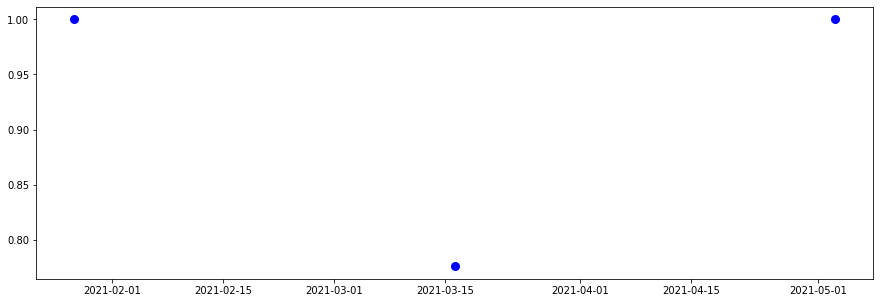

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize = (15,5))
plt.plot(coverage_table["times"].values, coverage_table["clean_percentage"].values, 'bo', markersize=8)
plt.show()

## Review an RGB scene for a selected time slice

In [11]:
# Load the data to create an RGB image

landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          output_crs=output_crs,
                          resolution=resolution,
                          measurements = ['red', 'green', 'blue']) 

In [12]:
from utils.dea_tools.plotting import rgb

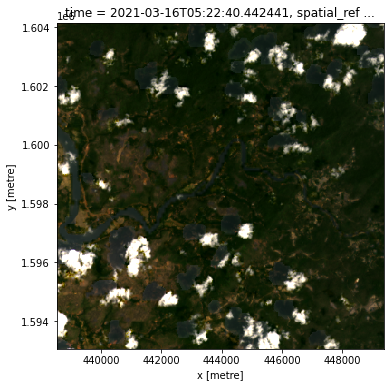

In [13]:
# CHANGE HERE >>>>>>>>>>>>>>

# Select one of the time slices and create an RGB image. 
# Time slices are numbered from 0 to x and shown in the table above
# Review the clean_percentage values above to select scenes with few clouds
# Clouds will be visible in WHITE and cloud-shadows will be visible in BLACK
%matplotlib inline
# rgb(landsat_dataset, at_index=11, figsize=(10,10), max_possible=3000)
rgb(landsat_dataset, index=1)